In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import datetime   # package that helps manipulate dates

#for decomposition:
from statsmodels.tsa.seasonal import seasonal_decompose

# Exponential smoothing methods
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline

# for time series cross validation
from sklearn.model_selection import TimeSeriesSplit

# used for autocorrelation and ARIMA/SARIMA
import statsmodels.api as sm

# for determining differencing in ARIMA models:
#statsmodels.tsa.stattools

# measuring MAE and RMSE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# this controls warnings (which are sometimes annoying)
from warnings import catch_warnings
from warnings import filterwarnings

# Making parameter selection iteration look less nasty:
import itertools

# kpss
from statsmodels.tsa.stattools import kpss

# ggplot for residuals
import plotnine

import matplotlib as mpl
# 
from sklearn.impute import SimpleImputer

In [70]:
# increase figure size
plt.rcParams['figure.figsize'] = [12, 8]
# increase plot text size
mpl.rc('font', size=15)

In [4]:
# turn warnings off when the code is working fine
filterwarnings("ignore")

# turn warnings back on when debugging
# warnings.filterwarnings("default")

In [37]:
#Importing data and cleaning to make a nice df with 2 columns

# import data (already cleaned on github)
df = pd.read_csv("./energy_generated.csv")

#renaming the columns since old code was all lower case, want to reuse 
df.rename(columns={
        'Date': 'date', 
        'Energy_Generated': 'energy_generated'
    }, inplace=True)

# reads date as date
df['date'] = pd.to_datetime(df['date'],format = '%b-%y')  


# check for missing dates... seems there are none
print(pd.date_range(
  start="1999-01-01", end="2021-06-01", freq = 'MS').difference(df['date']))



# further data cleaning and adding exogenous variables

# adding a dummy variable for 2014 when the trend changes
df['2014?'] = np.array((df.date >= '2014-01-01'), np.int16)

#adding in rain data
rain_data = pd.read_csv("./accumulate_rain_subsystem.csv")
rain_data['date'] = pd.to_datetime(rain_data['date'],format = '%Y-%m-%d')
df = pd.merge(df,rain_data, on = ['date'])
print(pd.date_range(
  start="2000-06-01", end="2020-12-01", freq = 'MS').difference(df['date'])) # check seems good

#
# dam_data = pd.read_csv("./Mean_Influent_Flow_per_Important_Dam.csv")
# dam_data['date'] = pd.to_datetime(dam_data['date'],format = '%Y-%m-%d')
# # dropping columns with many empty data
# dam_data.drop( axis=1, columns='BATALHA', inplace=True, errors='raise')
# dam_data.drop( axis=1, columns='SERRA DO FACAO', inplace=True, errors='raise')


# demand data
# we are not merging at this time because demand data is so sparse

# demand_data = pd.read_csv("Maximum_Demand.csv")
# demand_data.rename(columns={
#         'Date': 'date', 
#         'Maximum_Demand': 'maximum_demand'
#     }, inplace=True)
# demand_data['date'] = pd.to_datetime(rain_data['date'],format = '%b-%y')
# demand_data.info()
# df = pd.merge(df,demand_data, on = ['date'])

# influent flow and demand data (from 18 biggest)
dam_big_data = pd.read_csv("./Selected_important_dams_energy_demand_flow_monthly.csv.zip")
# inf_flow_data = pd.read_csv("./InfluentFlow_Subsystem.csv")
dam_data = dam_big_data[['year', 'month', 'date', 'influent_flow', 'maximum_demand']]
dam_data = dam_data.groupby(['year', 'month']).mean()
dam_data['date'] = pd.date_range(
  start="2000-01-01", end="2019-12-01", freq = 'MS')
dam_data.index = dam_data.date
dam_data = dam_data.drop(['date'], axis = 1)
df = pd.merge(df,dam_data, on = ['date'])


# influent flow not aggregated
dam_data2 = pd.read_csv("./Mean_Influent_Flow_per_Important_Dam.csv")
dam_data2['date'] = pd.to_datetime(dam_data2['date'],format = '%Y-%m-%d')
# dropping columns with many empty data
dam_data2.drop(axis=1, columns='BATALHA', inplace=True, errors='raise')
dam_data2.drop(axis=1, columns='SERRA DO FACAO', inplace=True, errors='raise')
dam_data2.drop(index = 167, axis = 0, inplace = True)
df = pd.merge(df,dam_data2, on = ['date'])


print(pd.date_range(start="2000-06-01", end="2019-12-01", freq = 'MS').difference(df['date']))
# df.head()

# df.info()

# removing the drought
# df = df[df['date'] >= '2002-01-01']
# df = df.reset_index(drop = True)

DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
DatetimeIndex([], dtype='datetime64[ns]', freq='MS')


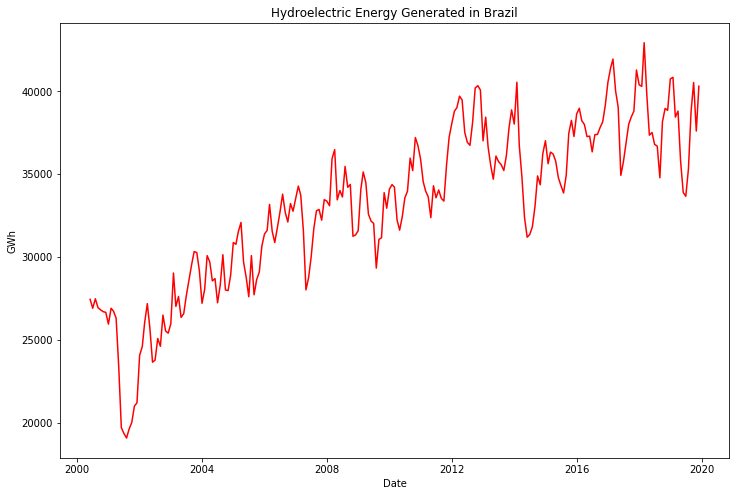

In [38]:
#plotting energy generated over full time period
plt.plot(df.date[:], df.energy_generated[:], 'r')   
plt.title('Hydroelectric Energy Generated in Brazil')
# Units not in GWh
plt.ylabel('GWh');
plt.xlabel('Date');
plt.show();

Now that we have plotted the data, we are going to start making predictions.  

We will give the mean error of each prediction $n$ months in advance after cross validating 12 times.  That is, for $n \in \{1,2,\cdots\, 12\}$, we will make a prediction for energy generated $n$ months from now, and use time series cross validation so that we make that prediction 12 times.  

The following function will choose optimal parameters for the SARIMA model based on minimizing the AIC on a training set that ignores the last 24 months (so that we don't test on any training data).

Exogenous variables may be included in the selection by changing the $x$ variable in the next cell.


In [39]:
df.columns

Index(['date', 'energy_generated', '2014?', 'date.1', 'year', 'month',
       'Total_accumulate', 'influent_flow', 'maximum_demand', 'BARRA BONITA',
       'CHAVANTES', 'COMPLEXO ILHA SOLTEIRA', 'EMBORCACAO', 'FURNAS', 'ITAIPU',
       'ITUMBIARA (FURNAS)', 'MAL. MASCARENHAS DE MORAES', 'MARIMBONDO',
       'NOVA PONTE', 'PARAIBUNA', 'SAO SIMAO (CEMIG)',
       'SEN. JOSE ERMIRIO DE MORAES', 'SERRA DA MESA', 'TRES IRMAOS',
       'TRES MARIAS'],
      dtype='object')

In [73]:
# number of cross validations (in case we want to change, probably shouldn't)
cross_splits = 24
# how many months are we going to check (Ivan wants 12)
tot_months = 12
# seasonality parameter is known (12 for monthly data)
m = 12

# removing test data for the parameter selection.  
# we can improve the model if we are willing to run computational time longer
df_param_selector = df.iloc[:-(cross_splits+tot_months),:].copy()

# choose exogenous variables for parameter selection:
x_param_sel = None
# x_param_sel = df_param_selector['Total_accumulate']
# x_param_sel = df_param_selector['influent_flow']
# x_param_sel = df_param_selector['maximum_demand']
# x_param_sel = df_param_selector[['maximum_demand','influent_flow']]
# x_param_sel = df_param_selector[['BARRA BONITA',
#        'CHAVANTES', 'COMPLEXO ILHA SOLTEIRA', 'EMBORCACAO', 'FURNAS', 'ITAIPU',
#        'ITUMBIARA (FURNAS)', 'MAL. MASCARENHAS DE MORAES', 'MARIMBONDO',
#        'NOVA PONTE', 'PARAIBUNA', 'SAO SIMAO (CEMIG)',
#        'SEN. JOSE ERMIRIO DE MORAES', 'SERRA DA MESA', 'TRES IRMAOS',
#        'TRES MARIAS']]

In [74]:
# difference function 
def difference_fct(timeseries):
    '''
    input: 1-d arraylike? object
    output: the difference 
    '''
    diff_series = timeseries.copy()
    for n in range(len(timeseries)):
        if n != 0:
            diff_series[n] = timeseries[n] - timeseries[n-1]
        else:
            pass
    diff_series.drop(index=diff_series.index[0],axis=0, inplace=True)
    diff_series.index = np.arange(len(diff_series))    
    return diff_series

# determine d in ARIMA 
def d_detector(timeseries):
    '''
    determines what the value of d should be in an ARIMA model
    input: 1-d arraylike? object
    output: how many differences do we need to do till we are stationary
    '''
    n = 0
    while kpss(timeseries)[1] < 0.05:
        timeseries = difference_fct(timeseries)
        n += 1
    
    return n

# seasonal_difference function

def diff_series_seas(timeseries, seas_len):
    '''
    computes seasonal difference
    input: 
        timeseries: 1-dim arraylike? object
        seas_len: integer, length of season (i.e. 12 for monthly data)
    output: 1-dim arraylike? object of length len(timeseries) - seas_len
    '''
    
    diff_series = timeseries.copy()
    
    listo = [i for i in range(0,len(timeseries)) if i not in range(0,seas_len)]

    for n in listo:
        diff_series[n] = timeseries[n] - timeseries[n-seas_len]
    
    diff_series.drop(index=diff_series.index[range(0,seas_len)],axis=0, inplace=True)
    diff_series.index = np.arange(len(diff_series)) 
    
    return diff_series

# determine D in SARIMA

def d_det_seas(timeseries, seas_len):
    '''
    determines what the value of d should be in a SARIMA model
    Will max out at D = 1
    input: 
        timeseries: 1-dim arraylike? object
        seas_len: integer, length of season (i.e. 12 for monthly data)
    output: appropriate D and d for seasonal data (max D = 1)
    '''
    timeseries = diff_series_seas(timeseries, seas_len)
    
    d = 0
    
    while kpss(timeseries)[1] < 0.1:
        timeseries = difference_fct(timeseries)
        d += 1
    
    return d

In [75]:
# using built-in function to create all possible parameter values
# (p,q,P,Q)
# # commented out most of the time because this algorithm is slooooooowwwwww

# we are assuming that the data is seasonal, period 12
D = 1
d = d_det_seas(df_param_selector['energy_generated'], 12)

param_set = itertools.product([0,1,2],[d],[0,1,2],[0,1,2],[D],[0,1,2])

# extracting the column we need
nrg_gen = df_param_selector['energy_generated']

# list of top 3 AIC initialized
aic_list = [5000,5000.1,5000.2,5000.3,5000.4]

# initialize a dictionary of best parameters:
best_param_dict = {aic_list[0]: [],
                   aic_list[1]: [],
                   aic_list[2]: [],
                   aic_list[3]: [],
                   aic_list[4]: []}

for p,d,q,P,D,Q in param_set:  
    # need try because sometimes things don't converge fast enough and we get runtime errors
    try:
        # never show warnings when grid searching, too noisy
        with catch_warnings():
            filterwarnings("ignore")
            mod = sm.tsa.statespace.SARIMAX(nrg_gen, exog = x_param_sel, order=(p,d,q), seasonal_order=(P,D,Q,m), simple_differencing=True)
            res = mod.fit(disp=False)
    except:
        pass
    # the restriction res.aic > 1500 is to rule out models that ended up overfit (can get AIC of 8, when others are like 4000.... but it performs bad on test set)
    if (res.aic < np.min(aic_list)) & (res.aic > 1500):
        del best_param_dict[max(aic_list)]
        best_param_dict[res.aic]=[p,d,q,P,D,Q]
        aic_list=list(best_param_dict.keys())
        
[p,d,q,P,D,Q] = best_param_dict[np.min(list(best_param_dict.keys()))]
    


In [12]:
print(x_param_sel)
print(best_param_dict)
print(p,d,q,P,D,Q)
print(x_param_sel)
print(df['influent_flow'])

None


In the previous cell, parameters are automatically set by selecting the minimum AIC.  However, the best_param_dict dictionary has several other possible parameter choices.  We can examine the residuals and determine if they are mean zero, stationary, etc.  This is done in the following cells.

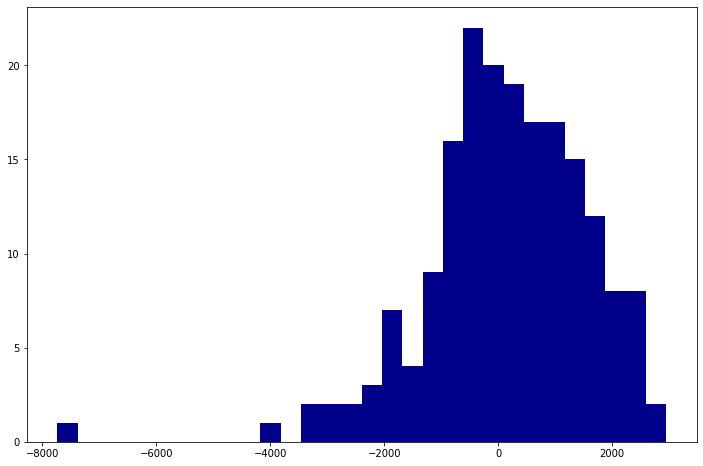

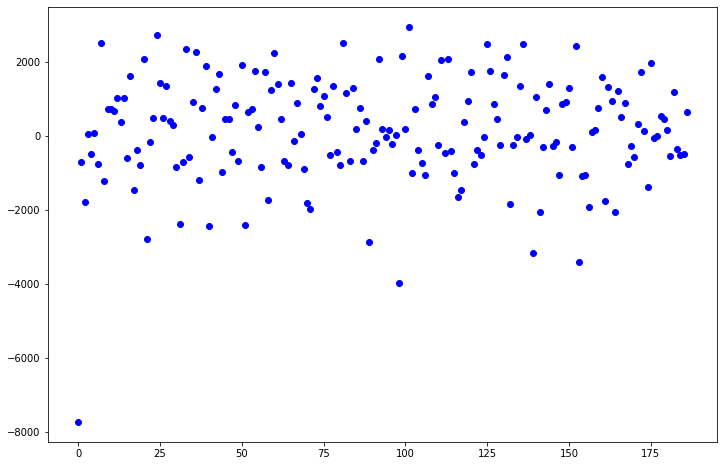

140.44539651915105


In [14]:
# plotting residuals

nrg_gen = df_param_selector['energy_generated']

# changing the index here (0 through 4) gives us 5 options of possible parameters to check
# [p,d,q,P,D,Q] = best_param_dict[list(best_param_dict.keys())[4]]
# the lowest AIC is given by this (same as default from above code)
# [p,d,q,P,D,Q] = best_param_dict[np.min(list(best_param_dict.keys()))]
# alternatively, for code testing when we don't want to spend 10 mins running grid search; parameters arbitrary
# [p,d,q,P,D,Q] = [1,1,0,0,1,0]
# [p,d,q,P,D,Q] = [1,0,0,0,1,0]


# building the model
mod = sm.tsa.statespace.SARIMAX(nrg_gen, exog = x_param_sel, order=(p,d,q), seasonal_order=(P,D,Q,m), simple_differencing=True)
res = mod.fit(disp=False)

# plot histogram of residuals
plt.hist(res.forecasts_error[0], bins = 30, color = 'darkblue')
plt.show()

# view residuals as functions of time
# color
# res_color = [x%12 for x in range(len(res.forecasts_error[0]))]
# pd_res = pd.DataFrame({'residuals': res.forecasts_error[0],'color': res_color})
# pd_res.plot(y = 'residuals', color = 'color')


# plt.scatter(x = list(range(len(res.forecasts_error[0]))), y = res.forecasts_error[0], color = res_color)
plt.plot(res.forecasts_error[0], 'bo')
plt.show()

# checking mean of the residuals (hope for close to 0)
print(np.mean(res.forecasts_error[0]))

Having selected parameters--either automatically through above algorithm, or more preferably by some analysis of the residuals--we now perform a cross validation in order to assess the accuracy of our model.  Note that the cross validation here is not choosing any parameters, but only attempting to get a more realistic view of the accuracy of our model.  

At the moment, accuracy is determined by the following formula:
$$\frac{100}{n}\sum_{i=1}^n\frac{|\hat{y}_i - y_i|}{y_i}$$
where $n$ is the number of cross validation splits we used.  That is, MAPE.

More specifically, the  cross validation works by checking each k month prediction as many times as we set the splits above.  In the current version of the code, we took 12 splits, and so each k month prediction happens 12 times, meaning each k month prediction looks at our ability to predict k months in advance while starting every month in the year.  Thus the mean in the MAPE above is taken by averaging the errors obtained by predicting January k months in advance, Febuary k months in advance,..., December k months in advance.  

However, there is a danger to this method of prediction.  For instance, we may obtain relatively good predictive accurary as measured by MAPE, but be consistantly predicting one of the months incorrectly (perhaps this model is very good at predicting energy in the summer but not the winter, or something like that).  Therefore we will also give a plot of the errors in each month in order to check the seasonality of our errors.  

In [151]:
# cross validation of SARIMA (allowing for exog)

# initializing a list to store CV error
CVerr_list = [0]*cross_splits
# initializing list of absolute percent error (reset each round)
per_err_list = [0]*cross_splits

# main variable for SARIMA
nrg_gen = df['energy_generated'].copy()

# exogenous variables
# x = None
# x = df['Total_accumulate'].copy()
# x = df['influent_flow'].copy()
# x = df['maximum_demand'].copy()
x = df[['maximum_demand','influent_flow']].copy()


# need a for loop so we can get accuracy of (n+1) months out for n 0-11:
for n in range(0,tot_months):
    # notice that gap is how many months between.  So n=0 corresponds to next month
    tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = 1, gap = n)
    # counter to put in list
    i = 0
    # for loop so that we can test over all of our cross validation splits
    for train_index, test_index in tscv.split(nrg_gen):
        y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
        if x is not None:  
            top_train = max(train_index)
            test_num = min(test_index)
            x_test_index = np.linspace(top_train + 1, test_num, test_num-top_train).astype(int)
            x_train, x_test = x.iloc[train_index], x.iloc[x_test_index]
        else:
            x_train, x_test = None, None
        # SARIMA
        fit =sm.tsa.statespace.SARIMAX(endog=y_train, exog=x_train, order=(p, d,q),seasonal_order=(P,D,Q,m)).fit()
        fcast = fit.forecast(n+1, exog = x_test)
        # printing parameters and MAE
        per_err = 100*(list(fcast)[-1] - y_test)/y_test
        per_err_list[i] = per_err
        i += 1
    CVerr_list[n] = per_err_list.copy()
    print('The CV MAPE of a prediction %s months in advance ' %(n+1), 'is %s' %np.mean(np.abs(CVerr_list[n])))

The CV MAPE of a prediction 1 months in advance  is 2.995778813271849
The CV MAPE of a prediction 2 months in advance  is 3.035085925021047
The CV MAPE of a prediction 3 months in advance  is 2.9737831342942633
The CV MAPE of a prediction 4 months in advance  is 3.0803409872378675
The CV MAPE of a prediction 5 months in advance  is 3.3550400201793757
The CV MAPE of a prediction 6 months in advance  is 3.4161043590756166
The CV MAPE of a prediction 7 months in advance  is 3.7289440857003
The CV MAPE of a prediction 8 months in advance  is 3.5355595810992817
The CV MAPE of a prediction 9 months in advance  is 3.840753058061782
The CV MAPE of a prediction 10 months in advance  is 3.645035572252237
The CV MAPE of a prediction 11 months in advance  is 3.8241202325010093
The CV MAPE of a prediction 12 months in advance  is 3.9289339454576258


We now plot the results of our prediction

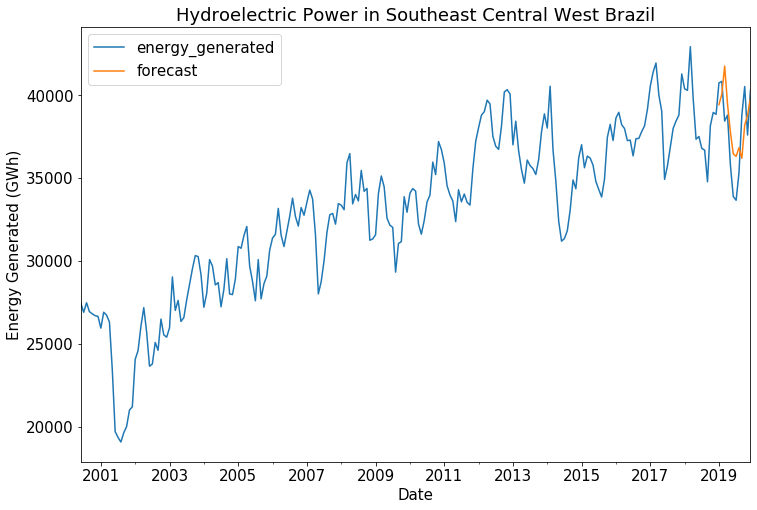

In [76]:
# Plotting results of SARIMA with exogenous variables

df_new = df.copy()
df_new.set_index('date', inplace = True)
# df_new = df_new[(df_new.index >= pd.to_datetime('2009-01-01',format = '%Y-%m-%d')) & (df_new.index <= pd.to_datetime('2020-03-01',format = '%Y-%m-%d'))]

nrg_gen = df_new['energy_generated'][:-tot_months]

#aligning indices with endogenous
# x = df_new[['maximum_demand', 'influent_flow']]
x = None

if x is None:
    model=sm.tsa.statespace.SARIMAX(nrg_gen,  order=(p, d, q),seasonal_order=(P,D,Q,m))
    results=model.fit()
    df_new['forecast'] = results.predict(start = len(nrg_gen), end = len(nrg_gen)+tot_months, dynamic = False)
else: 
    # building exog train variables for plotting
#     xtrain = nrg_gen.copy()
#     xtrain_entries = x[:-tot_months]
#     for tau in range(len(xtrain)):
#         xtrain[tau] = xtrain_entries[tau]
    
    xtrain = x.iloc[:-tot_months]
    # building test exog for plotting
    xtest_entries = x.iloc[-(tot_months):]

    model=sm.tsa.statespace.SARIMAX(nrg_gen, exog = xtrain, order=(p, d, q),seasonal_order=(P,D,Q,m))
    results=model.fit()
    df_new['forecast'] = np.nan
    fcast = results.forecast(tot_months, exog = xtest_entries)
    df_new['forecast'][-tot_months:] = fcast

    
# plotting
df_new[['energy_generated','forecast']].plot(figsize=(12,8))
# plt.plot(df_new.date[:], df_new.forecast[:], '-r')
plt.title('Hydroelectric Power in Southeast Central West Brazil')
plt.ylabel('Energy Generated (GWh)');
plt.xlabel('Date');
plt.savefig('foo.png')
plt.show()

In [58]:
# using built-in function to create all possible parameter values
# (p,q,P,Q)
# # commented out most of the time because this algorithm is slooooooowwwwww

# we are assuming that the data is seasonal, period 12
D = 1
d = d_det_seas(df_param_selector['energy_generated'], 12)

param_set = itertools.product([0,1,2],[d],[0,1,2],[0,1,2],[D],[0,1,2])

# extracting the column we need
nrg_gen = df_param_selector['energy_generated']

# list of top 3 AIC initialized
aic_list = [5000,5000.1,5000.2,5000.3,5000.4]

# initialize a dictionary of best parameters:
best_param_dict = {aic_list[0]: [],
                   aic_list[1]: [],
                   aic_list[2]: [],
                   aic_list[3]: [],
                   aic_list[4]: []}

for p,d,q,P,D,Q in param_set:  
    # need try because sometimes things don't converge fast enough and we get runtime errors
    try:
        # never show warnings when grid searching, too noisy
        with catch_warnings():
            filterwarnings("ignore")
            mod = sm.tsa.statespace.SARIMAX(x, order=(p,d,q), seasonal_order=(P,D,Q,m), simple_differencing=True)
            res = mod.fit(disp=False)
    except:
        pass
    # the restriction res.aic > 1500 is to rule out models that ended up overfit (can get AIC of 8, when others are like 4000.... but it performs bad on test set)
    if (res.aic < np.min(aic_list)) & (res.aic > 1500):
        del best_param_dict[max(aic_list)]
        best_param_dict[res.aic]=[p,d,q,P,D,Q]
        aic_list=list(best_param_dict.keys())
        
[pX,dX,qX,PX,DX,QX] = best_param_dict[np.min(list(best_param_dict.keys()))]
    


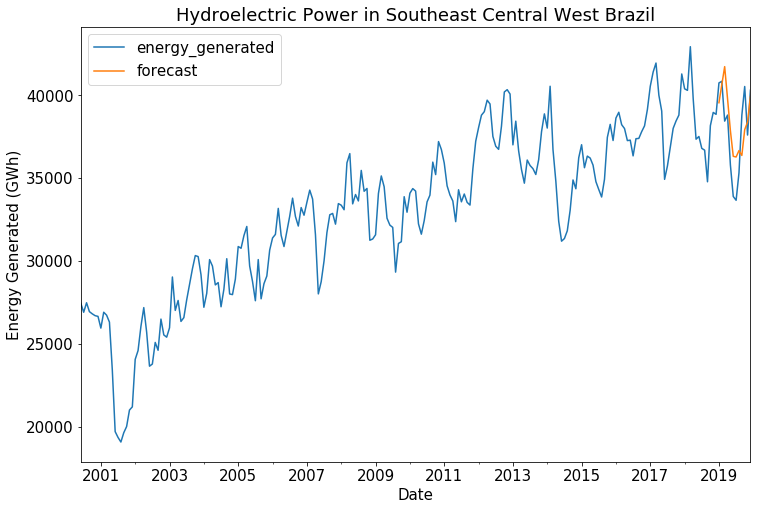

In [71]:
# Plotting results of SARIMA with exogenous variables

df_new = df.copy()
df_new.set_index('date', inplace = True)
# df_new = df_new[(df_new.index >= pd.to_datetime('2009-01-01',format = '%Y-%m-%d')) & (df_new.index <= pd.to_datetime('2020-03-01',format = '%Y-%m-%d'))]

nrg_gen = df_new['energy_generated'][:-tot_months]

#aligning indices with endogenous
x = df_new['influent_flow']
# x = df_new[['maximum_demand', 'influent_flow']]

if x is None:
    model=sm.tsa.statespace.SARIMAX(nrg_gen,  order=(p, d, q),seasonal_order=(P,D,Q,m))
    results=model.fit()
    df_new['forecast'] = results.predict(start = len(nrg_gen), end = len(nrg_gen)+tot_months, dynamic = False)
else: 
    # building exog train variables for plotting
#     xtrain = nrg_gen.copy()
#     xtrain_entries = x[:-tot_months]
#     for tau in range(len(xtrain)):
#         xtrain[tau] = xtrain_entries[tau]
    
    xtrain = x.iloc[:-tot_months]
    # building test exog for plotting
    modelX=sm.tsa.statespace.SARIMAX(xtrain, order=(pX, dX, qX),seasonal_order=(PX,DX,QX,m))
    resultsX=modelX.fit()
    fcastX = resultsX.forecast(tot_months, exog = None)

    model=sm.tsa.statespace.SARIMAX(nrg_gen, exog = xtrain, order=(p, d, q),seasonal_order=(P,D,Q,m))
    results=model.fit()
    df_new['forecast'] = np.nan
    
    fcast = results.forecast(tot_months, exog = fcastX)
    df_new['forecast'][-tot_months:] = fcast

    
# plotting
df_new[['energy_generated','forecast']].plot(figsize=(12,8))
# plt.plot(df_new.date[:], df_new.forecast[:], '-r')
plt.title('Hydroelectric Power in Southeast Central West Brazil')
plt.ylabel('Energy Generated (GWh)');
plt.xlabel('Date');
plt.savefig('foo.png')
plt.show()

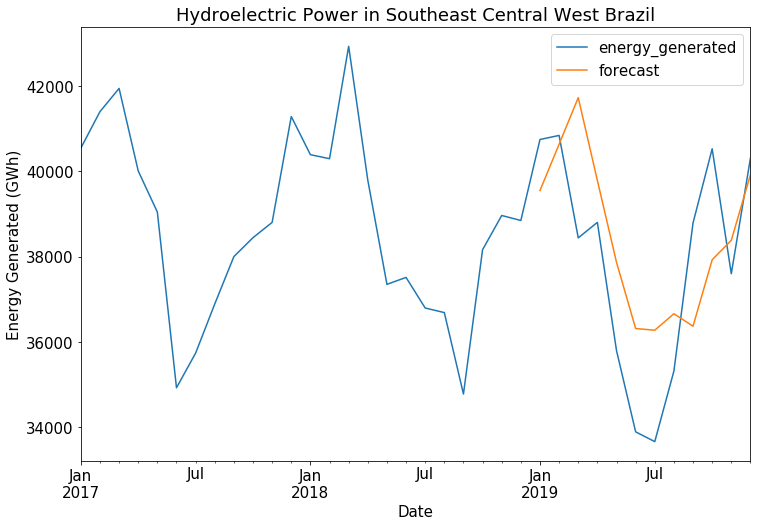

In [72]:
# plotting
df_new.iloc[-36:][['energy_generated','forecast']].plot(figsize=(12,8))
plt.title('Hydroelectric Power in Southeast Central West Brazil')
plt.ylabel('Energy Generated (GWh)');
plt.xlabel('Date');
plt.savefig('foo.png')
plt.show()

In [62]:
xtrain

date
2000-06-01    1681.059644
2000-07-01    1622.057527
2000-08-01    1590.026495
2000-09-01    1776.302644
2000-10-01    1625.567178
                 ...     
2018-08-01    1112.105427
2018-09-01    1053.243412
2018-10-01    1342.589564
2018-11-01    1524.833137
2018-12-01    1380.589981
Name: influent_flow, Length: 223, dtype: float64

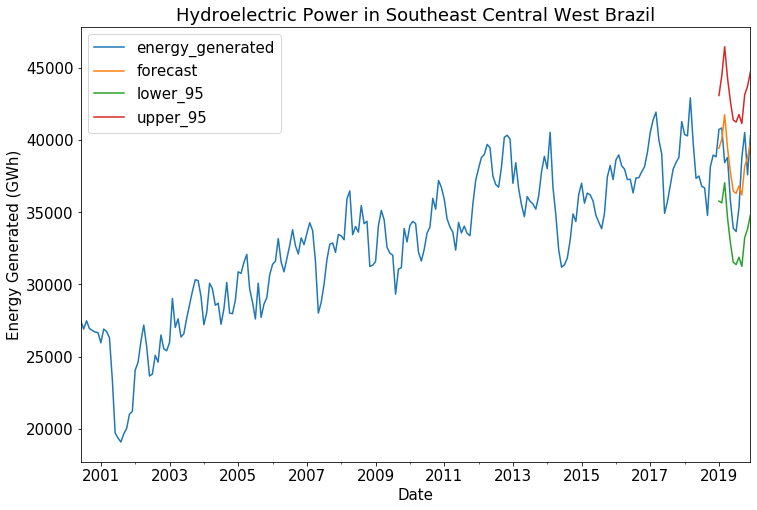

In [77]:
# Plotting results of SARIMA no exog
# with error bounds

df_new = df.copy()
df_new.set_index('date', inplace = True)

nrg_gen = df_new['energy_generated'][:-tot_months]

#aligning indices with endogenous
# x = df_new[['maximum_demand', 'influent_flow']]
x = None

model=sm.tsa.statespace.SARIMAX(nrg_gen,  order=(p, d, q),seasonal_order=(P,D,Q,m))
results=model.fit()
df_new['forecast'] = results.predict(start = len(nrg_gen), end = len(nrg_gen)+tot_months, dynamic = False)
# 95% confidence interval: https://machinelearningmastery.com/time-series-forecast-uncertainty-using-confidence-intervals-python/
forecast_info = results.get_forecast(12)
a = 0.05
ci = forecast_info.conf_int(alpha = a)
df_new['lower_95'] = ci['lower energy_generated']
df_new['upper_95'] = ci['upper energy_generated']

# print(ci[0,0],ci[0,1])
    


    
# plotting
df_new[['energy_generated','forecast','lower_95','upper_95']].plot(figsize=(12,8))
plt.title('Hydroelectric Power in Southeast Central West Brazil')
plt.ylabel('Energy Generated (GWh)');
plt.xlabel('Date');
plt.savefig('foo.png')
plt.show()

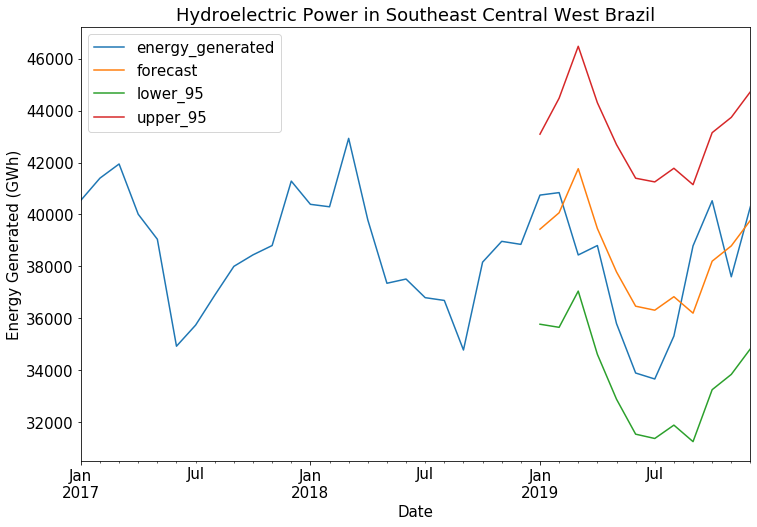

In [78]:
# plotting
df_new.iloc[-36:][['energy_generated','forecast','lower_95','upper_95']].plot(figsize=(12,8))
plt.title('Hydroelectric Power in Southeast Central West Brazil')
plt.ylabel('Energy Generated (GWh)');
plt.xlabel('Date');
plt.savefig('foo.png')
plt.show()

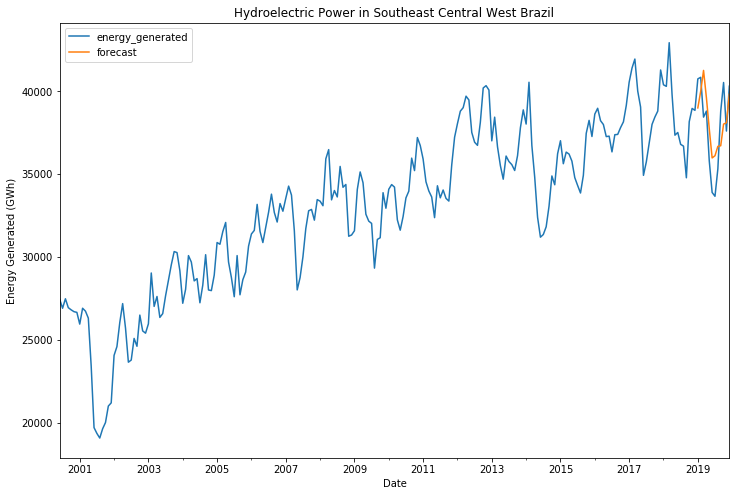

In [49]:
# Plotting results of SARIMA with exogenous variables

df_new = df.copy()
df_new.set_index('date', inplace = True)
# df_new = df_new[(df_new.index >= pd.to_datetime('2009-01-01',format = '%Y-%m-%d')) & (df_new.index <= pd.to_datetime('2020-03-01',format = '%Y-%m-%d'))]

nrg_gen = df_new['energy_generated'][:-tot_months]

#aligning indices with endogenous
x = df_new['influent_flow']

if x is None:
    model=sm.tsa.statespace.SARIMAX(nrg_gen,  order=(p, d, q),seasonal_order=(P,D,Q,m))
    results=model.fit()
    df_new['forecast'] = results.predict(start = len(nrg_gen), end = len(nrg_gen)+tot_months, dynamic = False)
else: 
    xtrain = x.iloc[:-tot_months]
    # building test exog for plotting
    xtest_entries = x.iloc[-(tot_months):]
    model=sm.tsa.statespace.SARIMAX(nrg_gen, exog = xtrain, order=(p, d, q),seasonal_order=(P,D,Q,m))
    results=model.fit()
    df_new['forecast'] = np.nan
    fcast = results.forecast(tot_months, exog = xtest_entries)
    df_new['forecast'][-tot_months:] = fcast
    forecast_info = results.get_forecast(12, exog = xtest_entries)
    a = 0.05
    ci = forecast_info.conf_int(alpha = a)
    df_new['lower_95'] = ci['lower energy_generated']
    df_new['upper_95'] = ci['upper energy_generated']

    
# plotting
df_new[['energy_generated','forecast']].plot(figsize=(12,8))
# plt.plot(df_new.date[:], df_new.forecast[:], '-r')
plt.title('Hydroelectric Power in Southeast Central West Brazil')
plt.ylabel('Energy Generated (GWh)');
plt.xlabel('Date');
plt.savefig('foo.png')
plt.show()

In [53]:
ci

,lower energy_generated,upper energy_generated
2019-01-01,35718.188008,42275.961274
2019-02-01,35918.628503,44060.902297
2019-03-01,36817.005335,45700.263001
2019-04-01,34983.172066,44243.042965
2019-05-01,33005.338518,42462.933252
2019-06-01,31197.928304,40760.908512
2019-07-01,31304.132945,40923.710516
2019-08-01,31853.599739,41503.693248
2019-09-01,31881.279380,41547.860852
2019-10-01,33183.794788,42859.294813


In [47]:
x

date
2000-06-01    1681.059644
2000-07-01    1622.057527
2000-08-01    1590.026495
2000-09-01    1776.302644
2000-10-01    1625.567178
                 ...     
2019-08-01    1043.769374
2019-09-01    1220.679059
2019-10-01    1231.679791
2019-11-01    1111.649157
2019-12-01    1459.270304
Name: influent_flow, Length: 235, dtype: float64

As mentioned in the last large text cell, we have a danger of consistantly making bad guesses in the same month while still getting a small MAPE.  The following cell plots the errors in each month.

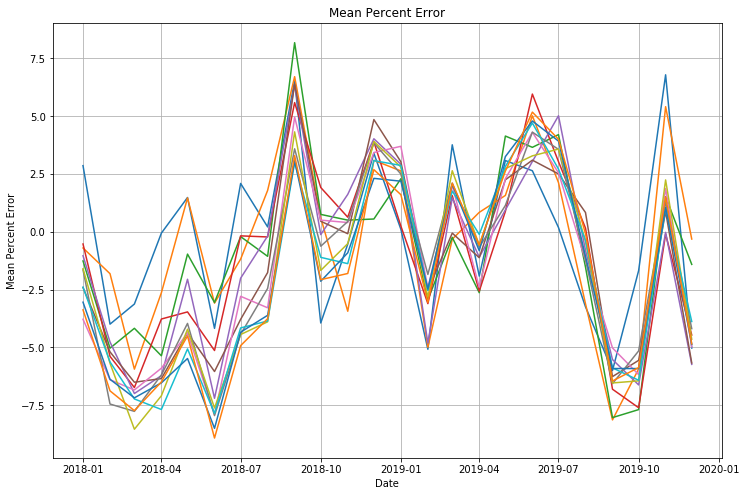

In [154]:
date_list = pd.date_range(start="2018-01-01", end="2019-12-01", freq = 'MS')
# date_list = list(range(cross_splits))

for n in range(0,tot_months):
    plt.plot(date_list, list(CVerr_list[n])) #the label won't work, I have no idea why

plt.title('Mean Percent Error')
plt.ylabel('Mean Percent Error');
plt.xlabel('Date');

plt.savefig('error_plot.png')


# grid_bot = range(1, 10)
# plt.plot(grid_bot, [xi*1 for xi in grid_bot])
# plt.plot(grid_bot, [xi*2 for xi in grid_bot])
# plt.plot(grid_bot, [xi*3 for xi in grid_bot])

plt.grid(b = True)
plt.show()

In [ ]:
for n in range(tot_months):
    print(CVerr_list[n])

In [ ]:
print(CVerr_list[4])
print(CVerr_list[9])

In [ ]:
# plotting residuals

nrg_gen = df_param_selector['energy_generated']

[p,d,q,P,D,Q, twen14] = best_param_dict[list(best_param_dict.keys())[0]]

if twen14:
    x = df_param_selector[['2014?']]
else:
    x = None

# [p,d,q,P,D,Q] = [1,1,0,0,1,0]


# building the model
mod = sm.tsa.statespace.SARIMAX(nrg_gen, exog = x, order=(p,d,q), seasonal_order=(P,D,Q,m), simple_differencing=True)
res = mod.fit(disp=False)

plt.hist(res.forecasts_error[0], bins = 30, color = 'darkblue')
plt.show()

plt.plot(res.forecasts_error[0], 'bo')
plt.show()

print(np.mean(res.forecasts_error[0]))

In [ ]:
# cross validation of SARIMA
print('We are predicting %s months in advance' %pred_length)


# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df['energy_generated']

# initializing list to store MAEs
mae_list = [0]*cross_splits  

#iteration for putting in mae_list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
#     print(train_index, test_index)
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    # SARIMA
    fit =sm.tsa.statespace.SARIMAX(y_train, order=(p, d,q),seasonal_order=(P,D,Q,m)).fit()
    fcast = fit.forecast(pred_length)
    # printing parameters and MAE
    mae = mean_absolute_error(fcast,y_test)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print('The CV MAE of SARIMA is %s' %np.mean(mae_list))
print('That is %s percent of the mean power output' %(100*(np.mean(mae_list)/np.mean(nrg_gen))))


In [ ]:
# cross validation of SARIMA with exog

# size of prediction window
pred_length = 3
# tell us how many days we are predicting
print('We are predicting %s months in advance' %pred_length)
# number of cross-validtion splits to do
cross_splits = 11
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df['energy_generated'].copy()
rainfall = df['2014?'].copy()

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    x_train, x_test = rainfall[train_index], rainfall[test_index]
    # SARIMA
    # Parameters basically random at this point
#     fit =sm.tsa.statespace.SARIMAX(y_test, order=(1, 1, 1),seasonal_order=(0,1,2,12)).fit()
    fit =sm.tsa.statespace.SARIMAX(endog=y_train, exog=x_train, order=(p, d,q),seasonal_order=(P,D,Q,m)).fit()
#     fit =sm.tsa.statespace.SARIMAX(y_test, order=(0, 0,1),seasonal_order=(2,0,1,m)).fit()
    fcast = fit.forecast(pred_length, exog = x_test)
#     fit = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
#     fcast = fit.forecast(pred_length).rename("Holt-Winter multiplicative")
    # printing parameters and MAE
    mae = mean_absolute_error(fcast,y_test)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print('The CV MAE of SARIMA is %s' %np.mean(mae_list))
print('That is %s percent of the mean power output' %(100*(np.mean(mae_list)/np.mean(nrg_gen))))

In [ ]:
print('That is %s percent of the mean power output' %(100*(np.mean(mae_list)/np.mean(nrg_gen))))

In [ ]:
# # commented out most of the time because this algorithm is slooooooowwwwww

# # initializing parameter lists:
# p_list = [0, 1, 2]
# d_list = [0,1]
# q_list = [0, 1, 2]
# P_list = [0, 1, 2]
# D_list = [0,1]
# Q_list = [0, 1, 2]

# # initialize the AIC to beat based on the randomly selected parameters from above
# best_aic = 5000
# # initialize parameters
# best_p,best_d, best_q,best_P,best_D, best_Q = 0,0,0,0,0,0


# # seasonality is always 12 since monthly data, pattern over years
# m = 12

# # prediction window
# pred_length = 3

# # getting training data
# nrg_gen = df['energy_generated'].copy()
# nrg_gen = nrg_gen[:-pred_length]

# # initializing list for params

# for p in p_list:
#     for d in d_list:
#         for q in q_list:
#             for P in P_list:
#                 for D in D_list:
#                     for Q in Q_list:
#                         try:
#                             # never show warnings when grid searching, too noisy
#                             with catch_warnings():
#                                 filterwarnings("ignore")
#                                 mod = sm.tsa.statespace.SARIMAX(nrg_gen, order=(p,d,q), seasonal_order=(P,D,Q,m), simple_differencing=True)
#                                 res = mod.fit(disp=False)
#                         except:
#                             pass
#                         if (res.aic < best_aic) & (res.aic > 1000):
#                             best_p,best_d,best_q,best_P,best_D,best_Q = p,d,q,P,D,Q
#                             best_aic = res.aic

# print('best aic is %s' %best_aic)
# param_list = [best_p,best_d,best_q,best_P,best_D,best_Q]
# print('(p,d,q,P,D,Q) = ') 
# print(*param_list, sep = ", ")

In [ ]:
# best parameter choices found by minimizing AIC

p = 1
d = 1 
q = 1

P = 0
D = 1 # not from AIC
Q = 2

m =12 # always



In [ ]:
# cross validation of SARIMA

# size of prediction window
pred_length = 3
# tell us how many days we are predicting
print('We are predicting %s months in advance' %pred_length)
# number of cross-validtion splits to do
cross_splits = 11
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df['energy_generated']

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    # SARIMA
    # Parameters basically random at this point
#     fit =sm.tsa.statespace.SARIMAX(y_test, order=(1, 1, 1),seasonal_order=(0,1,2,12)).fit()
    fit =sm.tsa.statespace.SARIMAX(y_test, order=(p, d,q),seasonal_order=(P,D,Q,m)).fit()
#     fit =sm.tsa.statespace.SARIMAX(y_test, order=(0, 0,1),seasonal_order=(2,0,1,m)).fit()
    fcast = fit.forecast(pred_length)
#     fit = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
#     fcast = fit.forecast(pred_length).rename("Holt-Winter multiplicative")
    # printing parameters and MAE
    mae = mean_absolute_error(fcast,y_test)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print('The CV MAE of SARIMA is %s' %np.mean(mae_list))
print('That is %s percent of the mean power output' %(np.mean(mae_list)/np.mean(nrg_gen)))


In [ ]:
# Plotting results of SARIMA

df_new = df.copy()
df_new.set_index('date', inplace = True)
df_new = df_new[(df_new.index >= pd.to_datetime('2009-01-01',format = '%Y-%m-%d')) & (df_new.index <= pd.to_datetime('2020-03-01',format = '%Y-%m-%d'))]


nrg_gen = df_new['energy_generated'][:-pred_length]

model=sm.tsa.statespace.SARIMAX(nrg_gen, order=(p, d, q),seasonal_order=(P,D,Q,m))
results=model.fit()
df_new['forecast']=results.predict(start=pd.to_datetime('2020-01-01',format = '%Y-%m-%d'),end=pd.to_datetime('2020-03-01',format = '%Y-%m-%d'),dynamic=False)


df_new[['energy_generated','forecast']].plot(figsize=(12,8))

#plotting energy generated over full time period
# plt.plot(df_new.date[:], df_new.energy_generated[:], '-b', label = 'Energy Generated')   
# # plt.plot(x, y1, "-b", label="fish")

# plt.plot(df_new.date[:], df_new.forecast[:], '-r')
plt.title('Hydroelectric Power in Southeast Central West Brazil')
# Units not in GWh
plt.ylabel('Energy Generated (GWh)');
plt.xlabel('Date');

plt.savefig('foo.png')


plt.show()

Cell below modifies SARIMA to use exogenous variables

In [ ]:
# using built-in function to create all possible parameter values
# (p,d,q,P,D,Q,2014?)
param_set = itertools.product([0,1,2],[0,1],[0,1,2],[0,1,2],[0,1],[0,1,2],[True,False])

# extracting the column we need
nrg_gen = df_param_selector['energy_generated']

# list of top 3 AIC initialized
aic_list = [5000,5000.1,5000.2]

# initialize a dictionary of best parameters:
best_param_dict = {aic_list[0]: [],
                  aic_list[1]: [],
                  aic_list[2]: []}

for p,d,q,P,D,Q, twen14 in param_set:  
    if twen14:
        x = df_param_selector[['2014?']]
    else:
        x = None
    try:
        # never show warnings when grid searching, too noisy
        with catch_warnings():
            filterwarnings("ignore")
            mod = sm.tsa.statespace.SARIMAX(nrg_gen, exog = x, order=(p,d,q), seasonal_order=(P,D,Q,m), simple_differencing=True)
            res = mod.fit(disp=False)
    except:
        pass
    if (res.aic < np.min(aic_list)) & (res.aic > 1000):
        del best_param_dict[max(aic_list)]
        best_param_dict[res.aic]=[p,d,q,P,D,Q, twen14]
        aic_list=list(best_param_dict.keys())
    
# # commented out most of the time because this algorithm is slooooooowwwwww




In [ ]:
# # using built-in function to create all possible parameter values
# # (p,d,q,P,D,Q)
# # # commented out most of the time because this algorithm is slooooooowwwwww

# param_set = itertools.product([0,1,2],[0,1],[0,1,2],[0,1,2],[0,1],[0,1,2])

# # extracting the column we need
# nrg_gen = df_param_selector['energy_generated']

# # list of top 3 AIC initialized
# aic_list = [5000,5000.1,5000.2,5000.3,5000.4]

# # initialize a dictionary of best parameters:
# best_param_dict = {aic_list[0]: [],
#                    aic_list[1]: [],
#                    aic_list[2]: [],
#                    aic_list[3]: [],
#                    aic_list[4]: []}

# for p,d,q,P,D,Q in param_set:  
#     # need try because sometimes things don't converge fast enough and we get runtime errors
#     try:
#         # never show warnings when grid searching, too noisy
#         with catch_warnings():
#             filterwarnings("ignore")
#             mod = sm.tsa.statespace.SARIMAX(nrg_gen, exog = x, order=(p,d,q), seasonal_order=(P,D,Q,m), simple_differencing=True)
#             res = mod.fit(disp=False)
#     except:
#         pass
#     # the restriction res.aic > 1500 is to rule out models that ended up overfit (can get AIC of 8, when others are like 4000.... but it performs bad on test set)
#     if (res.aic < np.min(aic_list)) & (res.aic > 1500):
#         del best_param_dict[max(aic_list)]
#         best_param_dict[res.aic]=[p,d,q,P,D,Q]
#         aic_list=list(best_param_dict.keys())
        
# [p,d,q,P,D,Q] = best_param_dict[np.min(list(best_param_dict.keys()))]
    


In [95]:
dam_pivot = dam_big_data.pivot(index='date', columns='dam', values=['influent_flow', 'maximum_demand']).copy()
# print(dam_pivot.head())
dam_pivot.drop(labels=None, axis=1, index=None, columns='BATALHA', level=1, inplace=True, errors='raise')
dam_pivot.drop(labels=None, axis=1, index=None, columns='SERRA DO FACAO', level=1, inplace=True, errors='raise')
dam_pivot.head()

# # dam_pivot['maximum_demand']['BATALHA'].head(50)
dam_pivot['influent_flow'].columns
for col in dam_pivot['maximum_demand'].columns:
    print(col)
    print(dam_pivot['maximum_demand'][col].isnull().sum())
    
for col in dam_pivot['influent_flow'].columns:
    print(col)
    print(dam_pivot['influent_flow'][col].isnull().sum())
print(np.where(pd.isnull(dam_pivot)))
print(len(dam_pivot))

BARRA BONITA
1
CHAVANTES
1
COMPLEXO ILHA SOLTEIRA
1
EMBORCACAO
1
FURNAS
1
ITAIPU
1
ITUMBIARA (FURNAS)
1
MARIMBONDO
1
NOVA PONTE
1
PARAIBUNA
1
SAO SIMAO (CEMIG)
1
SEN. JOSE ERMIRIO DE MORAES
1
SERRA DA MESA
1
TRES IRMAOS
1
TRES MARIAS
1
BARRA BONITA
1
CHAVANTES
1
COMPLEXO ILHA SOLTEIRA
1
EMBORCACAO
1
FURNAS
1
ITAIPU
1
ITUMBIARA (FURNAS)
1
MARIMBONDO
1
NOVA PONTE
1
PARAIBUNA
1
SAO SIMAO (CEMIG)
1
SEN. JOSE ERMIRIO DE MORAES
1
SERRA DA MESA
1
TRES IRMAOS
1
TRES MARIAS
1
(array([167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167,
       167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167,
       167, 167, 167, 167]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]))
241


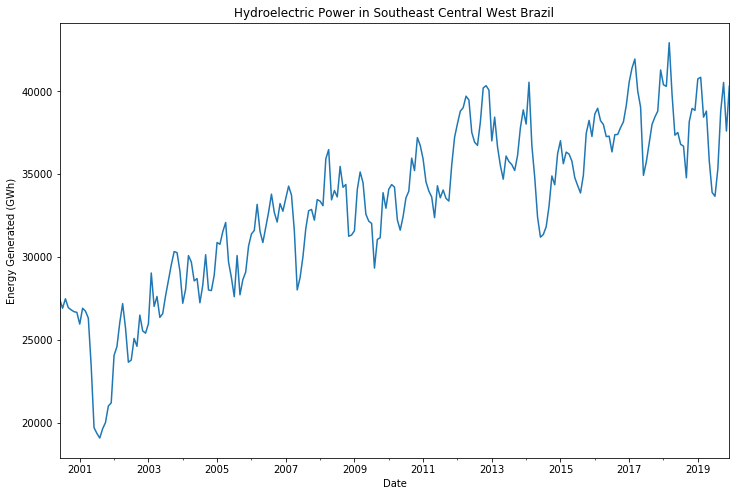

In [56]:
# plotting
df_new['energy_generated'].plot(figsize=(12,8))
# plt.plot(df_new.date[:], df_new.forecast[:], '-r')
plt.title('Hydroelectric Power in Southeast Central West Brazil')
plt.ylabel('Energy Generated (GWh)');
plt.xlabel('Date');
plt.savefig('foo.png')
plt.show()